# Assessing the magnitude distributions of the stars

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import Pool
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [2]:
# from funcs.star_survey import star_survey#, reader
import sys
sys.path.append('../')
wdir = '/disk1/hrb/python/'
from funcs.analysis.obj_survey import obj_survey#, reader
from funcs.preprocessing.parse import intersection, filter_data

# PS colors

In [ ]:
ps_colors = ps.df.groupby(['uid_s','filtercode']).last().loc[pd.IndexSlice[:,['g','i']],'mag'].reset_index('filtercode').pivot(columns='filtercode',values='mag')
ps_colors.columns = ["_".join(x) for x in ps_colors.columns.ravel()]
ps_colors['gi'] = ps_colors['g']-ps_colors['i']

# SDSS colours

In [3]:
colors = pd.read_csv(wdir+'data/computed/calibStars/colors_sdss.csv', index_col=0)

In [4]:
colors = pd.DataFrame()
colors['gr'] = sdss.df['mag_g']-sdss.df['mag_r']
colors['ri'] = sdss.df['mag_r']-sdss.df['mag_i']
colors['gi'] = sdss.df['mag_g']-sdss.df['mag_i']
colors['iz'] = sdss.df['mag_i']-sdss.df['mag_z']
colors['ug'] = sdss.df['mag_u']-sdss.df['mag_g']

# bounds_clr = {'gr':(-0.6,1.6), 'ri':(-0.6,2), 'gi':(-0.6,2), 'iz':(-0.6,1.2), 'ug':(-0.6,3.5)}
bounds_clr = {color:(-0.6,3.5) for color in colors.columns}
colors = filter_data(colors, bounds_clr).dropna()

NameError: name 'sdss' is not defined

# Using raw (unaveraged) data

In [5]:
nrows = None
bounds_generic={'mag':(15,25),'magerr':(0,2)}

In [8]:
sdss = obj_survey('sdss', 'calibStars', 'uid_s')
sdss.read_in_raw(nrows)
sdss.df = filter_data(sdss.df, bounds_generic, bands = 'griz')

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


num obj before: 10,801,148
num obj after:  10,797,707


In [7]:
ps = obj_survey('ps', 'calibStars', 'uid_s')
ps.read_in_raw(nrows) 
ps.df = filter_data(ps.df, bounds_generic)

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


num obs before: 41,693,053
num obs after:  41,676,220


In [9]:
ztf = obj_survey('ztf', 'calibStars', 'uid_s')
ztf.read_in_raw(nrows)
ztf.df = filter_data(ztf.df, bounds_generic)

attempting parallel reading


/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


completed parallel reading
num obs before: 63,537,235
num obs after:  63,533,776


# Saving groupby frames

sdss.pivot(read_in=False, magerr=2)

ztf.transform_to_ps(colors=colors)
ztf.pivot(read_in=False, magerr=2)

ps.pivot(read_in=False, magerr=2)

In [10]:
# takes ~30s, could reduce but need to parallelise
sdss.df, ps.df, ztf.df = intersection(sdss.df,ps.df,ztf.df)
# sdss.df, ps.df = intersection(sdss.df,ps.df)

sdss before intersection: 10,797,707
ps   before intersection: 41,676,220
ztf  before intersection: 63,534,201
---------------------------------
sdss after  intersection: 9,274,598
ps   after  intersection: 35,736,837
ztf  after  intersection: 63,141,969
---------------------------------


In [25]:
ztf.df = ztf.df.reset_index('uid_s').set_index(['uid_s','filtercode'])
# ztf.df

In [31]:
ztf.df.index.get_level_values('filtercode').unique()

Index(['r', 'g', 'i'], dtype='object', name='filtercode')

In [27]:
ztf.transform_to_ps(colors=colors)

ValueError: columns overlap but no suffix specified: Index(['mean_gi', 'mean_gr', 'mean_ri', 'mean_iz'], dtype='object')

In [17]:
ps.df = ps.df.reset_index('filtercode')
ps.df

,filtercode,mjd,mag,magerr
uid_s,,,,
5,i,55027.444101,20.476408,0.097361
5,i,55027.455123,20.382079,0.075392
5,y,55342.583792,19.330926,0.185268
5,r,55427.326181,21.180085,0.130492
5,r,55427.337551,20.924990,0.111752
...,...,...,...,...
1006830,r,56977.481108,21.563815,0.194371
1006830,i,57001.392033,20.158091,0.046995
1006830,i,57001.403498,20.096325,0.046925


| band | max magerr |  SDSS |  PS   | ZTF   |
|------|------------|-------|-------|-------|
|  g   |     80%    | 0.0557| 0.0876| 0.1274|
|  r   |     80%    | 0.0358| 0.0597| 0.1154|
|  i   |     80%    | 0.0299| 0.0418| 0.0935|
|  z   |     80%    | 0.0637| 0.0557|   -   |


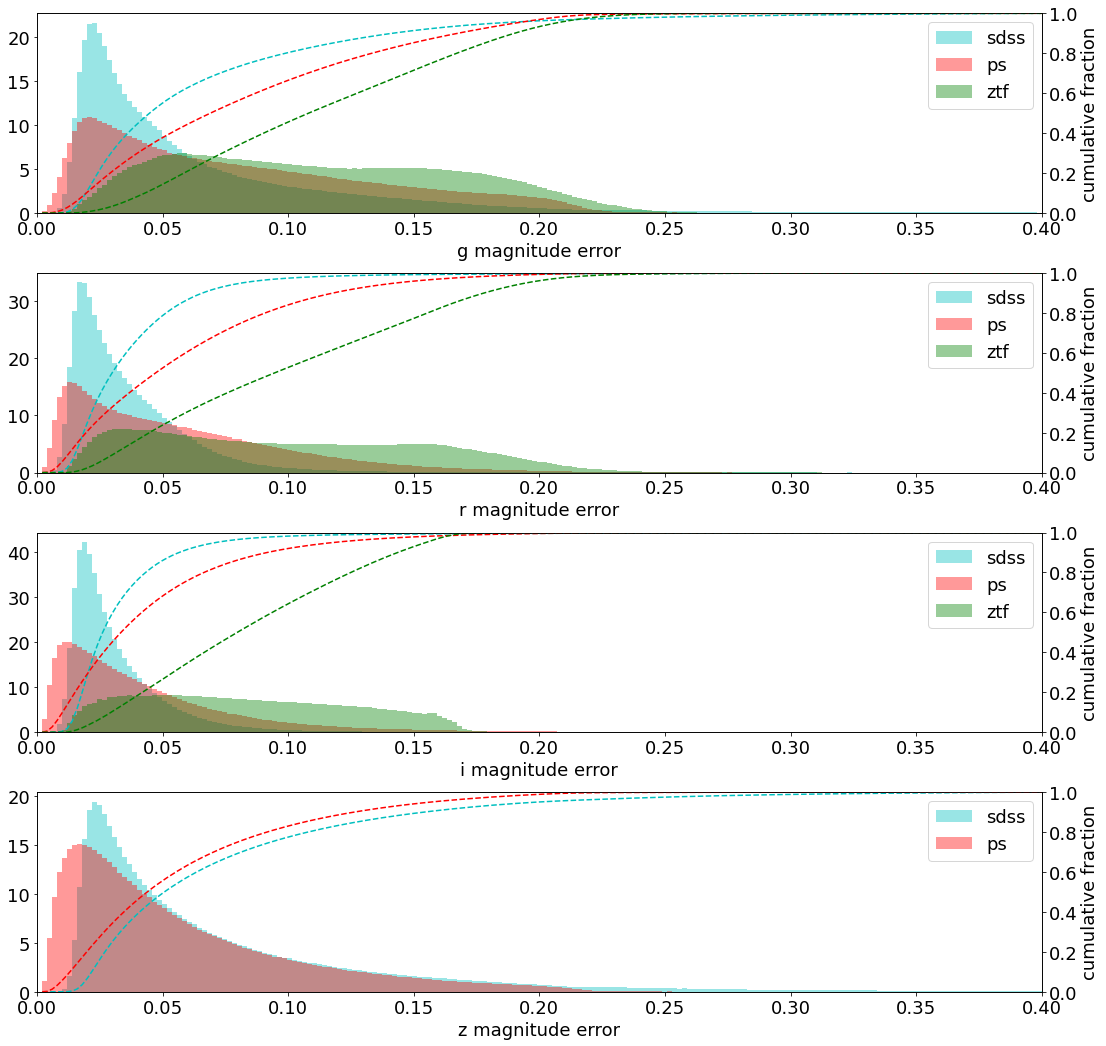

In [8]:
from funcs.plotting import plot_magerr_hist
ax = plot_magerr_hist([sdss, ps, ztf], bands='griz', quantiles=[0.09,0.10,0.11,0.12], show_lines=0, savename = 'plots/calibStars/stars_magerr_hist', magerr=0.6)

In [13]:
sdss.df

,mag_g,magerr_g,mag_r,magerr_r,mag_i,magerr_i,mag_z,magerr_z,mjd,g-r,r-i,i-z
uid_s,,,,,,,,,,,,
5,22.93179,0.246535,21.27677,0.084079,20.22893,0.050431,20.07873,0.166841,51465.129240,1.65502,1.04784,0.15020
5,23.11500,0.236284,21.33154,0.069858,20.35444,0.044607,19.69389,0.085466,52053.425802,1.78346,0.97710,0.66055
5,23.09120,0.196885,21.38830,0.054100,20.39286,0.036695,19.56136,0.070529,52172.226094,1.70290,0.99544,0.83150
5,22.81021,0.209917,21.33990,0.066690,20.29467,0.036207,19.85742,0.104544,52552.166049,1.47031,1.04523,0.43725
5,23.17127,0.206570,21.48485,0.076104,20.35254,0.039883,19.85021,0.090243,52931.077514,1.68642,1.13231,0.50233
...,...,...,...,...,...,...,...,...,...,...,...,...
755543,22.18744,0.175896,21.02030,0.068867,20.07219,0.044234,19.41712,0.087359,53312.240504,1.16714,0.94811,0.65507
755543,22.67346,0.140027,21.02779,0.067429,20.05275,0.044807,19.40890,0.086746,53314.241792,1.64567,0.97504,0.64385
755544,21.83982,0.071703,20.63154,0.039010,20.11641,0.044226,19.98498,0.141062,51075.338101,1.20828,0.51513,0.13143


In [22]:
sdss.df['catalogue'] = 1
ps  .df['catalogue'] = 2
ztf .df['catalogue'] = 3
cols = ['mjd','mag_ps','magerr','catalogue']
master = pd.concat([sdss.df[cols].reset_index(), ps.df[cols].reset_index(), ztf.df[cols].reset_index()], axis = 0, ignore_index = True).astype({sdss.ID:'int'}).set_index([sdss.ID, 'catalogue', 'filtercode'])

UInt64Index([      5,       6,      11,      16,      19,      21,      28,
                  29,      33,      37,
             ...
             1006806, 1006807, 1006808, 1006809, 1006812, 1006816, 1006817,
             1006822, 1006826, 1006830],
            dtype='uint64', name='uid_s', length=522580)

In [ ]:
for band in 'griz':
    chunks = np.array_split(master.loc[pd.IndexSlice[:, :, band], :].reset_index('filtercode', drop = True),4)
    for i in range(4):
        chunks[i].to_csv('/disk1/hrb/python/data/merged/qsos/lc_{}_{}.csv'.format(band, i))

In [10]:
def convert(mag_magerr):
    mag, magerr = mag_magerr.values.T
    flux     = 10**(-(mag-8.9)/2.5+6)
    flux_err = 0.92103403712*flux*magerr 
    return flux,flux_err

In [34]:
cols = [x for y in zip(['flux_'+b for b in 'ugriz'], ['fluxerr_'+b for b in 'ugriz']) for x in y]
a = pd.DataFrame(columns=cols)
for b in 'ugriz':
    flux, flux_err = convert(sdss.df[['mag_'+b,'magerr_'+b]])
    a['flux_'+b] = flux
    a['fluxerr_'+b] = flux_err

In [5]:
################
# sdss.pivot(read_in=False, magerr='_magerr_007')

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/disk1/hrb/python/analysis/funcs/obj_survey.py:48: RuntimeWarning: divide by zero encountered in power
  meanerr	 = np.nansum(magerr**-2,axis=0)**-0.5 #REDO THIS with **-0.5


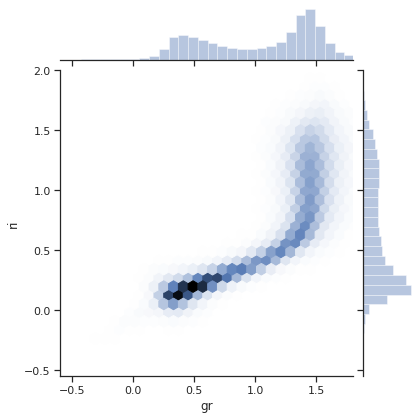

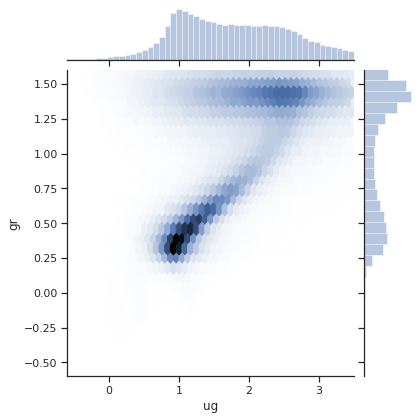

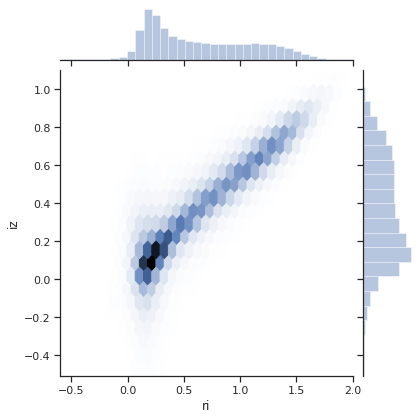

In [60]:
frac = 0.05
# sns.jointplot(x='gr',y='ri',data=colors.sample(frac=frac), kind='scatter', s=0.01, xlim=[-0.6,1.8], ylim=[-0.55,2])
# sns.jointplot(x='ug',y='gr',data=colors.sample(frac=frac), kind='scatter', s=0.01, xlim=[-0.6,3.5], ylim=[-0.6,1.6])
# sns.jointplot(x='ri',y='iz',data=colors.sample(frac=frac), kind='scatter', s=0.01, xlim=[-0.6,2], ylim=[-0.51,1.1])
# sns.set(style="ticks")
sns.jointplot(x='gr',y='ri',data=colors.sample(frac=frac), kind='hex', xlim=[-0.6,1.8], ylim=[-0.55,2])
sns.jointplot(x='ug',y='gr',data=colors.sample(frac=frac), kind='hex', xlim=[-0.6,3.5], ylim=[-0.6,1.6])
sns.jointplot(x='ri',y='iz',data=colors.sample(frac=frac), kind='hex', xlim=[-0.6,2.0], ylim=[-0.51,1.1])

In [ ]:
# uid_oid = pd.read_csv('/disk1/hrb/python/data/surveys/ztf/calibStars/calibStars_ztf.txt', skiprows = 59, usecols = [3,6], names=['uid_s','oid'], sep='\s+', index_col = 'oid')
# mask = uid_oid['oid'].duplicated()
# uid_oid = uid_oid[mask]
# test = ztf.df.join(uid_oid,on='oid')
# test

Checking match between control star sample and quasars

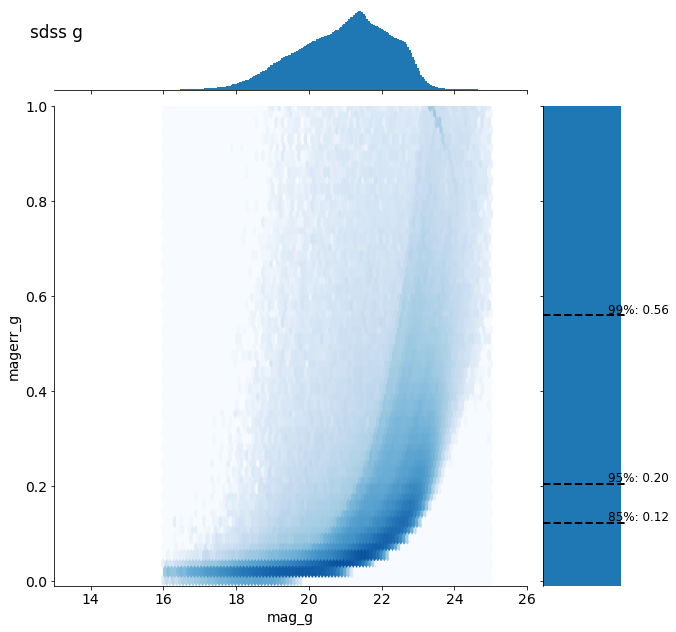

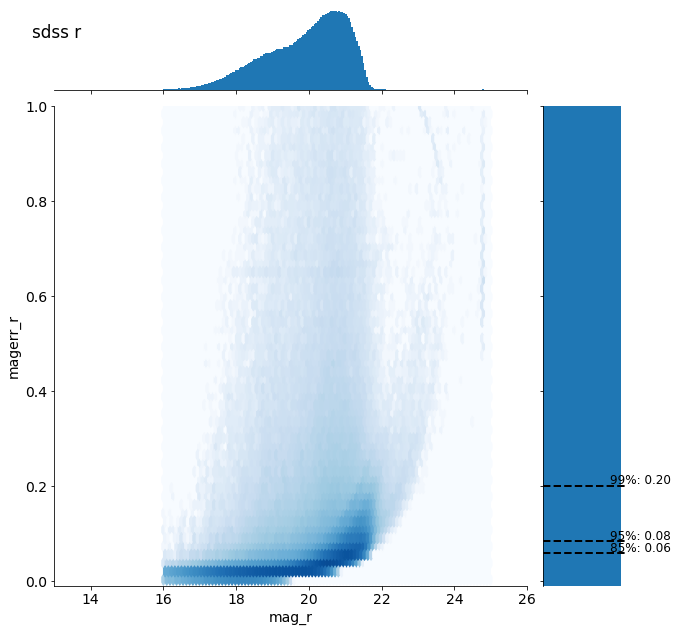

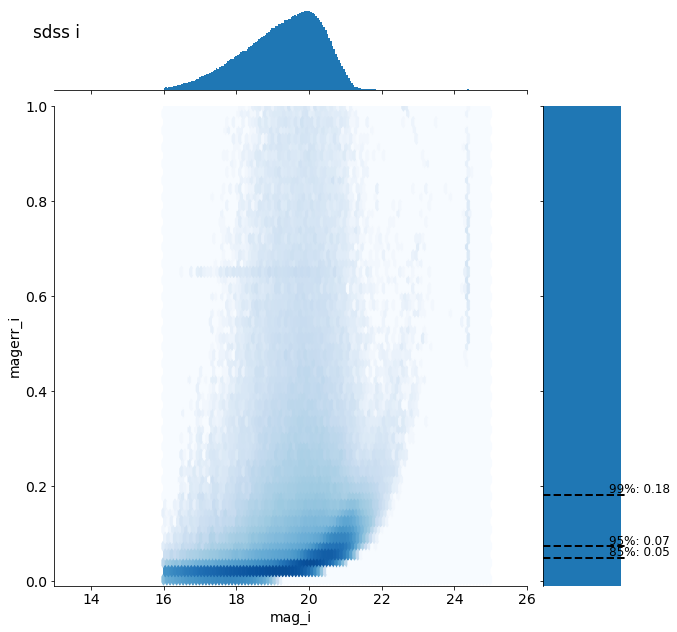

In [41]:
import seaborn as sns
sdss.correlate_mag_magerr_hist_sns('g', 2e0,1e6, save=0)
sdss.correlate_mag_magerr_hist_sns('r', 2e0,1e6, save=0)
sdss.correlate_mag_magerr_hist_sns('i', 2e0,1e6, save=0)

# Using averaged data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib
font = {'size' : 18}
matplotlib.rc('font', **font)

In [13]:
from funcs.obj_survey import obj_survey#, reader
from funcs.parse import intersection, filter_data

In [14]:
def compute_colors(survey):
    colors = pd.DataFrame()
    colors['mean_gi'] = survey.df_pivot['mean_g'] - survey.df_pivot['mean_i']
    colors['mean_gr'] = survey.df_pivot['mean_g'] - survey.df_pivot['mean_r']
    colors['mean_ri'] = survey.df_pivot['mean_r'] - survey.df_pivot['mean_i']
    colors['mean_iz'] = survey.df_pivot['mean_i'] - survey.df_pivot['mean_z']
    return colors

In [15]:
# colors = pd.read_csv('computed/colors_ps_last.csv', index_col=0)
colors = pd.read_csv('calibStars/computed/colors_sdss.csv', index_col=0)

| band | max magerr |  SDSS |  PS   | ZTF   |
|------|------------|-------|-------|-------|
|  g   |     60%    | 0.0557| 0.0876| 0.1274|
|  r   |     60%    | 0.0358| 0.0597| 0.1154|
|  i   |     60%    | 0.0299| 0.0418| 0.0935|
|  z   |     60%    | 0.0637| 0.0557|   -   |

| band | max magerr |  SDSS |  PS   | ZTF   |
|------|------------|-------|-------|-------|
|  g   |     70%    | 0.0736| 0.1075| 0.1473|
|  r   |     70%    | 0.0418| 0.0736| 0.1353|
|  i   |     70%    | 0.0358| 0.0517| 0.1095|
|  z   |     70%    | 0.0816| 0.0697|   -   |

| band | max magerr |  SDSS |  PS   | ZTF   |
|------|------------|-------|-------|-------|
|  g   |     80%    | 0.0995| 0.1333| 0.1672|
|  r   |     80%    | 0.0517| 0.0915| 0.1552|
|  i   |     80%    | 0.0438| 0.0657| 0.1254|
|  z   |     80%    | 0.1075| 0.0915|   -   |

| band | max magerr |  SDSS |  PS   | ZTF   |
|------|------------|-------|-------|-------|
|  g   |     90%    | 0.1413| 0.1672| 0.1910|
|  r   |     90%    | 0.0657| 0.1174| 0.1791|
|  i   |     90%    | 0.0557| 0.0915| 0.1433|
|  z   |     90%    | 0.1532| 0.1254|   -   |

In [3]:
#if any observation has a value outside these bounds, that observation is NaN'd
bounds_generic  = {'mean':(15,25), 'meanerr':(0,2)} 
bounds_specific_fn = lambda x: {'magerr_max_'+band:value for band,value in zip('griz',zip([0,0,0,0],x))}
bands = 'griz'
magerr = 2
pop = 80

print('SDSS')
sdss = obj_survey('sdss', 'calibStars', 'uid_s')
sdss.pivot(magerr=magerr)
# for b in bands:
#     sdss.df_pivot['mean_sdss_'+b] = sdss.df_pivot['mean_'+b]
# sdss.df_pivot = filter_data(sdss.df_pivot, bounds_generic, bounds_specific_fn([0.056, 0.036, 0.03, 0.064]), bands) #60
# sdss.df_pivot = filter_data(sdss.df_pivot, bounds_generic, bounds_specific_fn([0.074, 0.042, 0.036, 0.082]), bands) #70
sdss.df_pivot = filter_data(sdss.df_pivot, bounds_generic, bounds_specific_fn([0.100, 0.052, 0.044, 0.110]), bands) #80
# sdss.df_pivot = filter_data(sdss.df_pivot, bounds_generic, bounds_specific_fn([0.141, 0.066, 0.056, 0.153]), bands) #90
sdss.transform_avg_to_ps(colors, 'mean_gr', 'griz', system='tonry')
sdss.residual({'g':0.0148, 'r':0.0049, 'i':0.0198, 'z':0.042})

# colors = compute_colors(sdss)
# sdss.df_pivot = filter_data(sdss.df_pivot, {'mean_gi':(0.4,2.7)}) 

print('\nPS')
ps = obj_survey('ps', 'calibStars', 'uid_s')
ps.pivot(magerr=magerr)
# ps.df_pivot = filter_data(ps.df_pivot, bounds_generic, bounds_specific_fn([0.088, 0.060, 0.042, 0.056]), bands) #60
# ps.df_pivot = filter_data(ps.df_pivot, bounds_generic, bounds_specific_fn([0.108, 0.074, 0.052, 0.070]), bands) #70
ps.df_pivot = filter_data(ps.df_pivot, bounds_generic, bounds_specific_fn([0.133, 0.092, 0.062, 0.092]), bands) #80
# ps.df_pivot = filter_data(ps.df_pivot, bounds_generic, bounds_specific_fn([0.167, 0.112, 0.092, 0.125]), bands) #90
# duplicating rows to keep the naing convention consistent
for b in bands:
    ps.df_pivot['mean_ps_'+b] = ps.df_pivot['mean_'+b]

bands='gri'
print('\nZTF')
ztf = obj_survey('ztf', 'calibStars', 'uid_s')
ztf.pivot(magerr=magerr)
# ztf.df_pivot = filter_data(ztf.df_pivot, bounds_generic, bounds_specific_fn([0.127, 0.115, 0.094]), bands) #60
# ztf.df_pivot = filter_data(ztf.df_pivot, bounds_generic, bounds_specific_fn([0.147, 0.135, 0.110]), bands) #70
ztf.df_pivot = filter_data(ztf.df_pivot, bounds_generic, bounds_specific_fn([0.167, 0.155, 0.125]), bands) #80
# ztf.df_pivot = filter_data(ztf.df_pivot, bounds_generic, bounds_specific_fn([0.191, 0.172, 0.143]), bands) #90
ztf.residual({'g':0.0074, 'r':-0.0099, 'i':0})


SDSS


AttributeError: 'obj_survey' object has no attribute 'pivot'

In [10]:
sdss.df_pivot, ps.df_pivot, ztf.df_pivot = intersection(sdss.df_pivot, ps.df_pivot, ztf.df_pivot)
# sdss.df_pivot, ps.df_pivot  = intersection(sdss.df_pivot, ps.df_pivot)
# sdss.df_pivot, ztf.df_pivot = intersection(sdss.df_pivot, ztf.df_pivot)
# ztf.df_pivot , ps.df_pivot  = intersection(ztf.df_pivot , ps.df_pivot)

sdss before intersection: 475,354
ps   before intersection: 449,861
ztf  before intersection: 299,950
---------------------------------
sdss after  intersection: 277,556
ps   after  intersection: 277,556
ztf  after  intersection: 277,556
---------------------------------


In [11]:
ps.df_pivot = ps.df_pivot.join(colors, on=ps.ID)
ztf.df_pivot = ztf.df_pivot.join(colors, on=ztf.ID)
# ps.transform_avg_to_sdss(colors, bands = 'griz')
# ztf.transform_avg_to_sdss(colors, bands = 'gri')

In [14]:
# Cell below plots mag distribution for SDSS, PS, ZTF for each band, taking the intersection of all three surveys in each band in turn.

sdss before intersection: 225,257
ps   before intersection: 199,479
ztf  before intersection: 182,071
---------------------------------
sdss after  intersection: 162,830
ps   after  intersection: 162,830
ztf  after  intersection: 162,830
---------------------------------
sdss before intersection: 234,802
ps   before intersection: 239,063
ztf  before intersection: 254,200
---------------------------------
sdss after  intersection: 202,377
ps   after  intersection: 202,377
ztf  after  intersection: 202,377
---------------------------------
sdss before intersection: 229,724
ps   before intersection: 182,484
ztf  before intersection: 112,308
---------------------------------
sdss after  intersection: 72,325
ps   after  intersection: 72,325
ztf  after  intersection: 72,325
---------------------------------
sdss before intersection: 242,316
ps   before intersection: 211,993
---------------------------------
sdss after  intersection: 202,074
ps   after  intersection: 202,074
-----------------

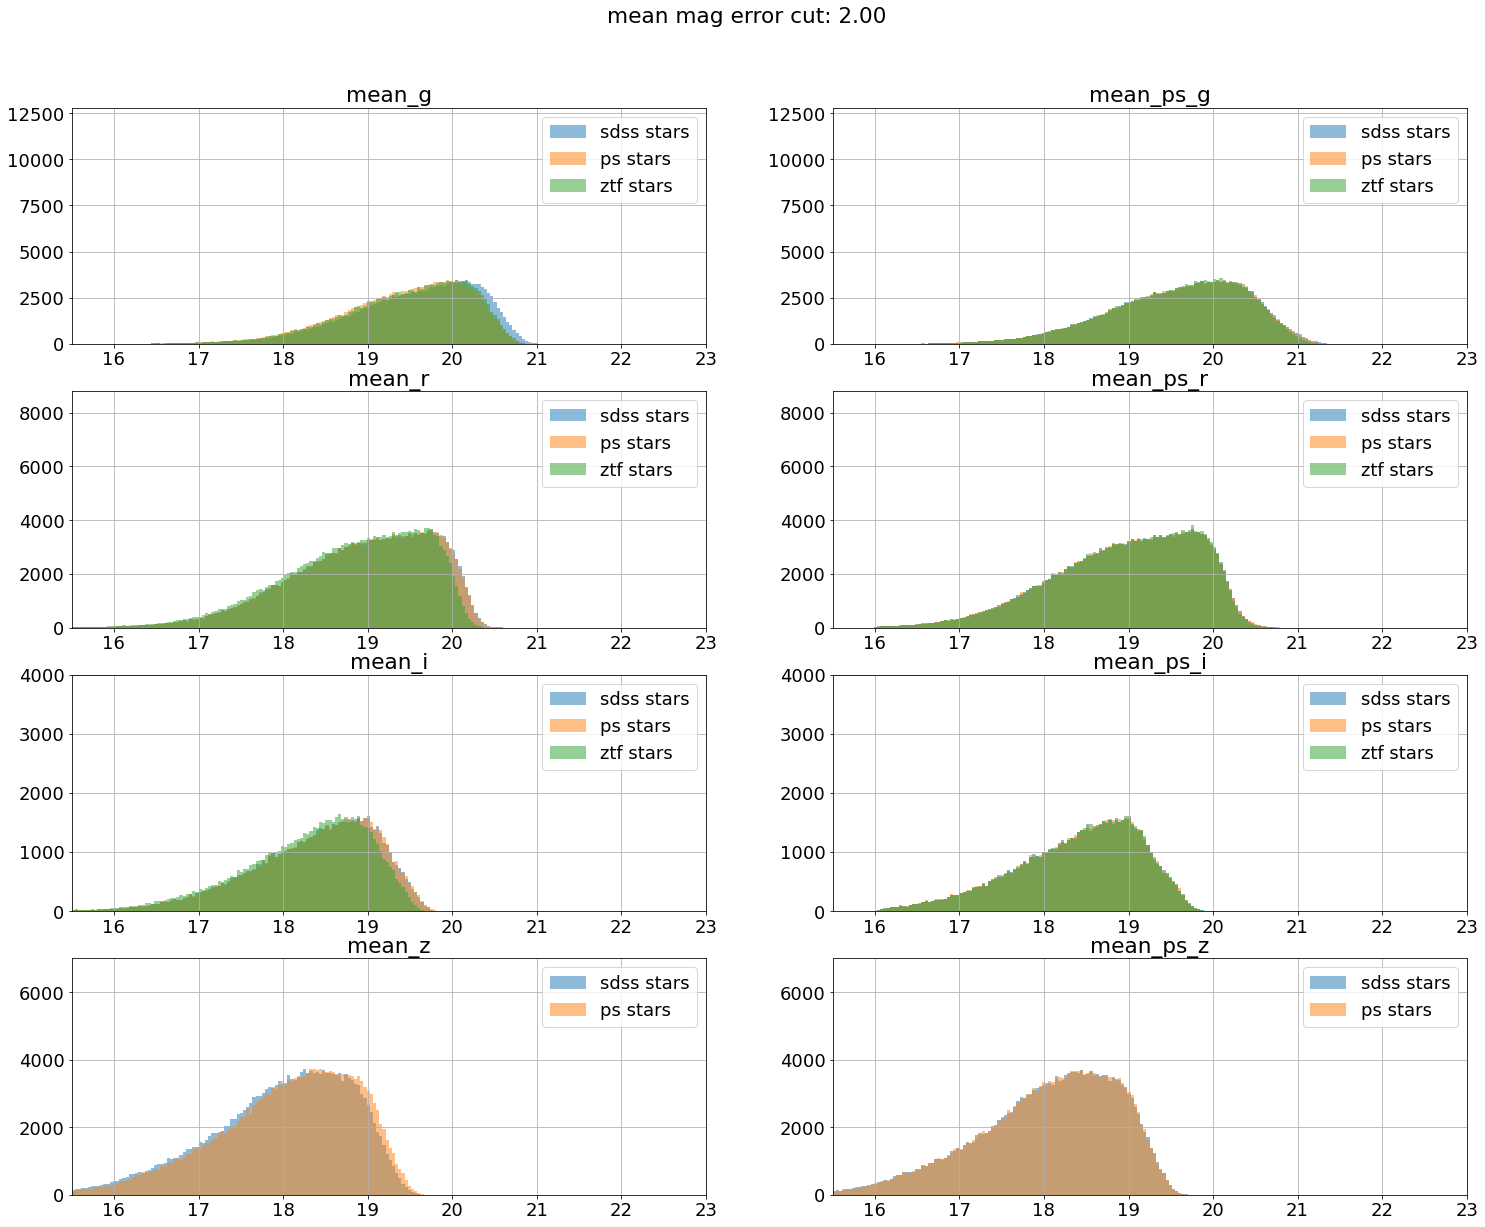

In [15]:
def plot_mag_dist(inner=True, save=False):
	fig, ax = plt.subplots(4,2, figsize = (25,20))
	scaling_dict = {'g':24000,'r':35500,'i':35500}
	hist_bounds = {'mean':(15.5,23)}
	ylims  = [(0,12800),(0,8800),(0,4000),(0,7000)]
    
	for j, col in enumerate(['','ps_']):
		for i,band in enumerate('griz'):

			sdss_data = sdss.df_pivot['mean_'+col+band].dropna()
			ps_data   = ps  .df_pivot['mean_'+band].dropna()

			if band != 'z':
				ztf_data  = ztf .df_pivot['mean_'+col+band].dropna()
				if inner:
					sdss_data, ps_data, ztf_data = intersection(sdss_data, ps_data, ztf_data)
			else:
				if inner:
					sdss_data, ps_data = intersection(sdss_data, ps_data)
				del ztf_data

			sdss_data.hist(ax=ax[i,j], bins=200, range=hist_bounds['mean'], alpha = 0.5, label = 'sdss stars')
			ps_data  .hist(ax=ax[i,j], bins=200, range=hist_bounds['mean'], alpha = 0.5, label = 'ps stars')
			try:
				ztf_data .hist(ax=ax[i,j], bins=200, range=hist_bounds['mean'], alpha = 0.5, label = 'ztf stars')
			except:
				pass

			ax[i,j].set(title='mean_'+col+band, xlim=hist_bounds['mean'], ylim=ylims[i])
			ax[i,j].legend()
	plt.suptitle('mean mag error cut: {:.2f}'.format(bounds_generic['meanerr'][1]), y=0.95)

	if save==True:
		fig.savefig('calibStars/plots/star_distn_comparison_intersection.pdf', bbox_inches='tight')
        
plot_mag_dist(inner=True, save=1)

# Color corrections

In [12]:
mag_bounds = [15,21]
system='_ps'
bins=81

In [13]:
sdss_mag_g = sdss.df_pivot['mean_g']
sdss.calculate_pop_mask('g', bounds=mag_bounds)

In [14]:
ps.calculate_pop_mask('g', bounds=mag_bounds)
ps.calculate_offset(sdss, system=system, bands='griz')


In [15]:
ztf.calculate_pop_mask('g', bounds=mag_bounds)
ztf.calculate_offset(sdss, system=system, bands='gri')
ztf.calculate_offset(ps, system=system, bands='gri')


#### Cells below plots the distribution of the offset (difference in average magnitude per quasar for each survey) for 5 populations of apparent brightness

Offset for 15<mag<21 population (uncalibrated):
ztf-sdss_g   -0.088924
ztf-sdss_r   -0.077245
ztf-sdss_i   -0.059192
dtype: float64

Offset for 15<mag<21 population (calibrated):
ztf'-sdss'_g   -0.010448
ztf'-sdss'_r   -0.003948
ztf'-sdss'_i    0.002400
dtype: float64



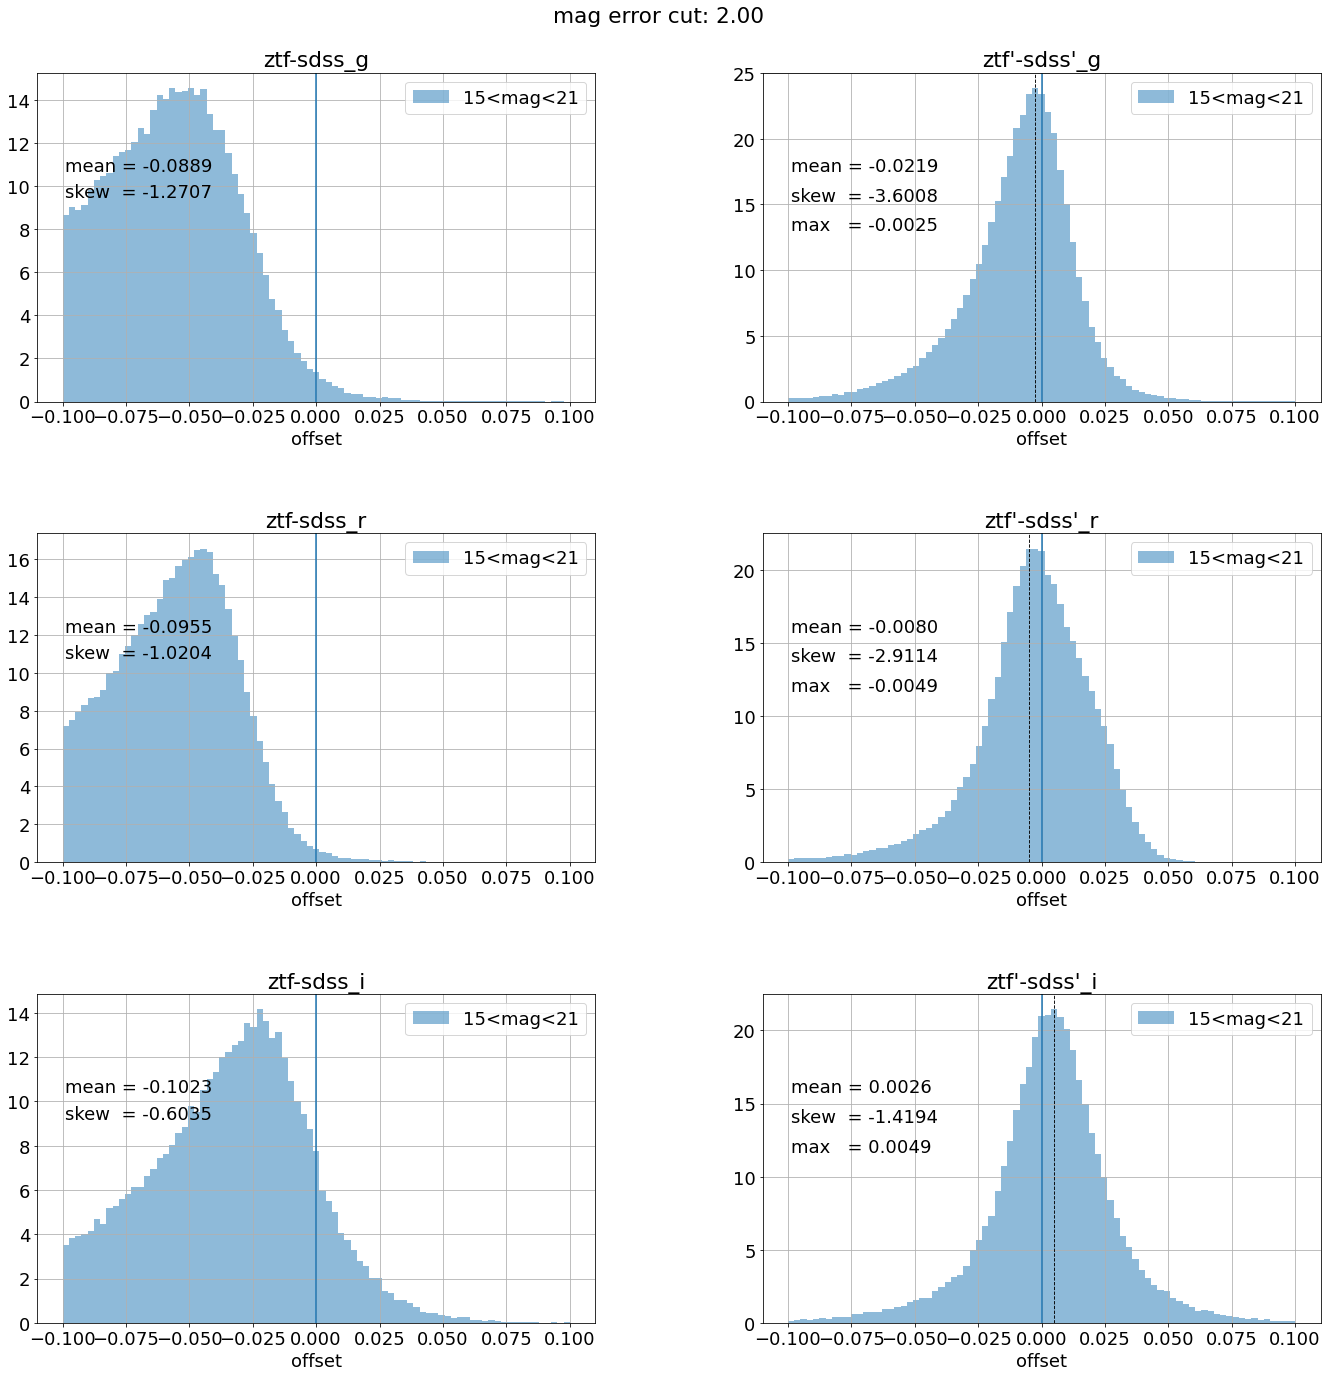

In [16]:
axes = ztf.plot_offset_distrib(sdss, bands='gri', scale='linear', save=0, range=(-0.1,0.1), density=1, bins=bins)

Offset for 15<mag<21 population (uncalibrated):
ps-sdss_g   -0.125773
ps-sdss_r   -0.002251
ps-sdss_i    0.010128
ps-sdss_z    0.068401
dtype: float64

Offset for 15<mag<21 population (calibrated):
ps'-sdss'_g   -0.004780
ps'-sdss'_r   -0.000675
ps'-sdss'_i   -0.001053
ps'-sdss'_z    0.001009
dtype: float64



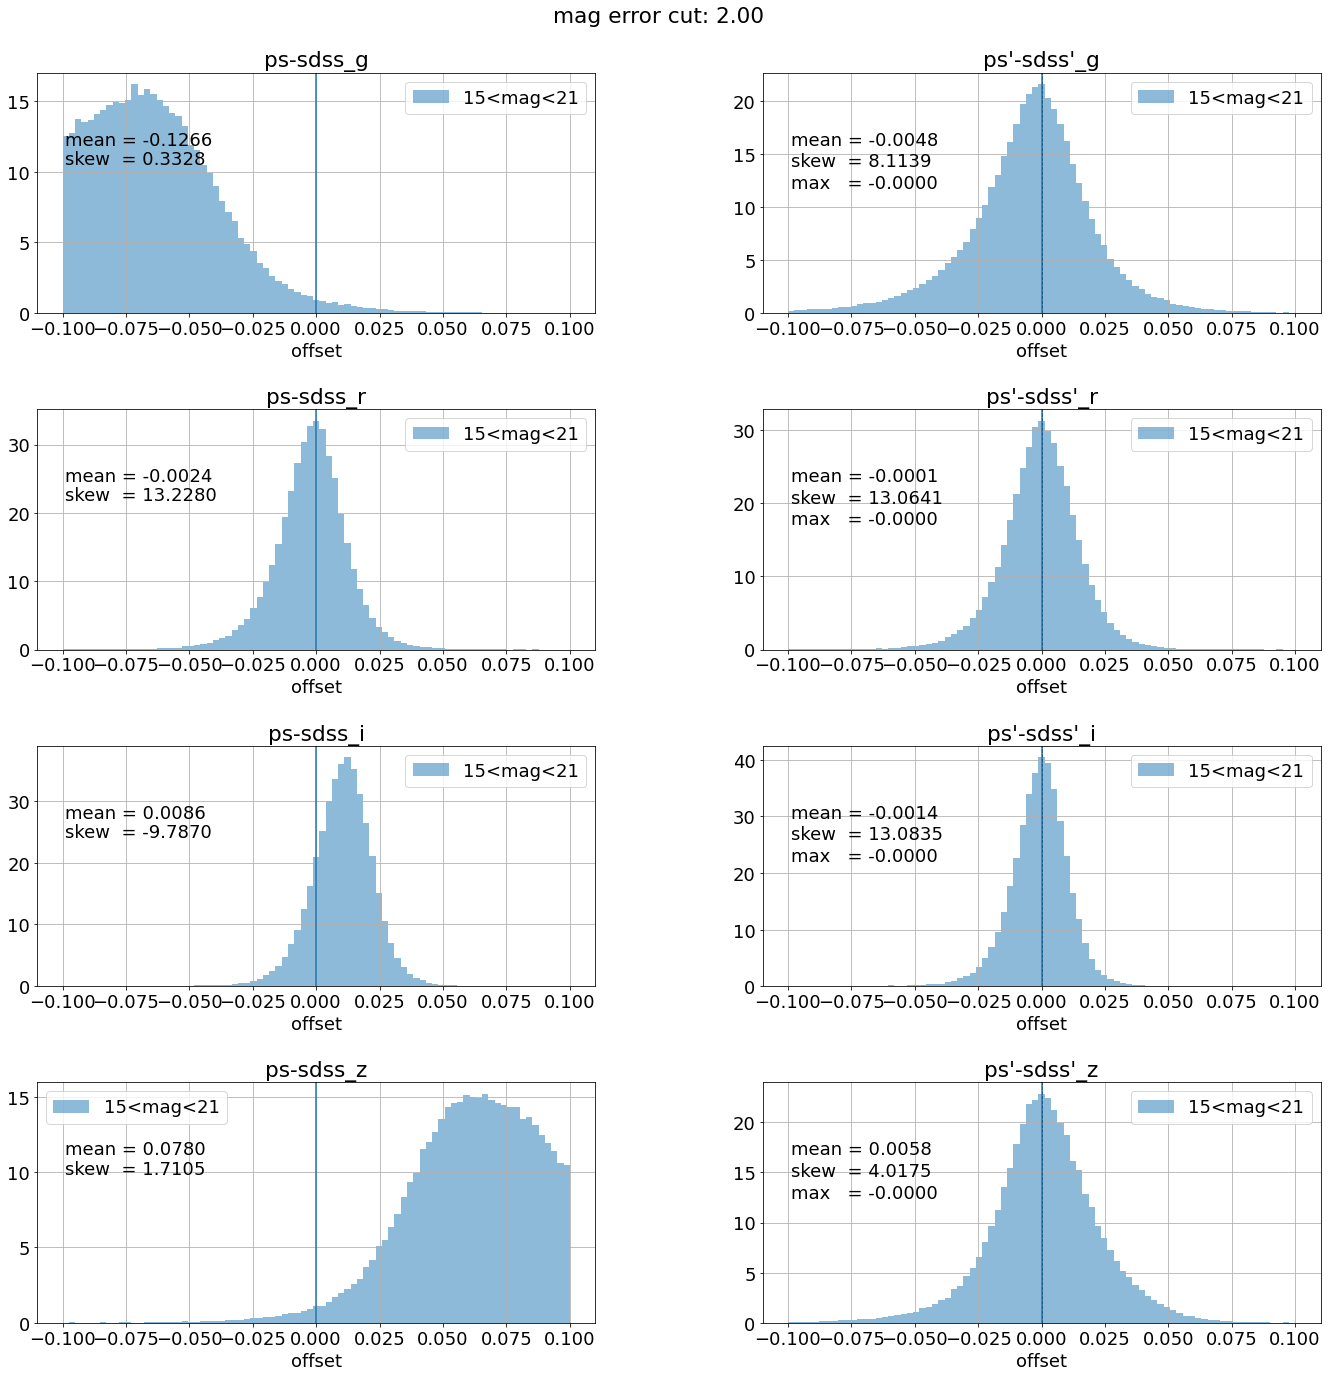

In [17]:
axes = ps.plot_offset_distrib(sdss, bands='griz', scale='linear', save=0, range=(-0.1,0.1), density=1, bins=bins)

Offset for 15<mag<21 population (uncalibrated):
ztf-ps_g    0.030093
ztf-ps_r   -0.075679
ztf-ps_i   -0.075560
dtype: float64

Offset for 15<mag<21 population (calibrated):
ztf'-ps'_g   -0.006557
ztf'-ps'_r   -0.003256
ztf'-ps'_i    0.002112
dtype: float64



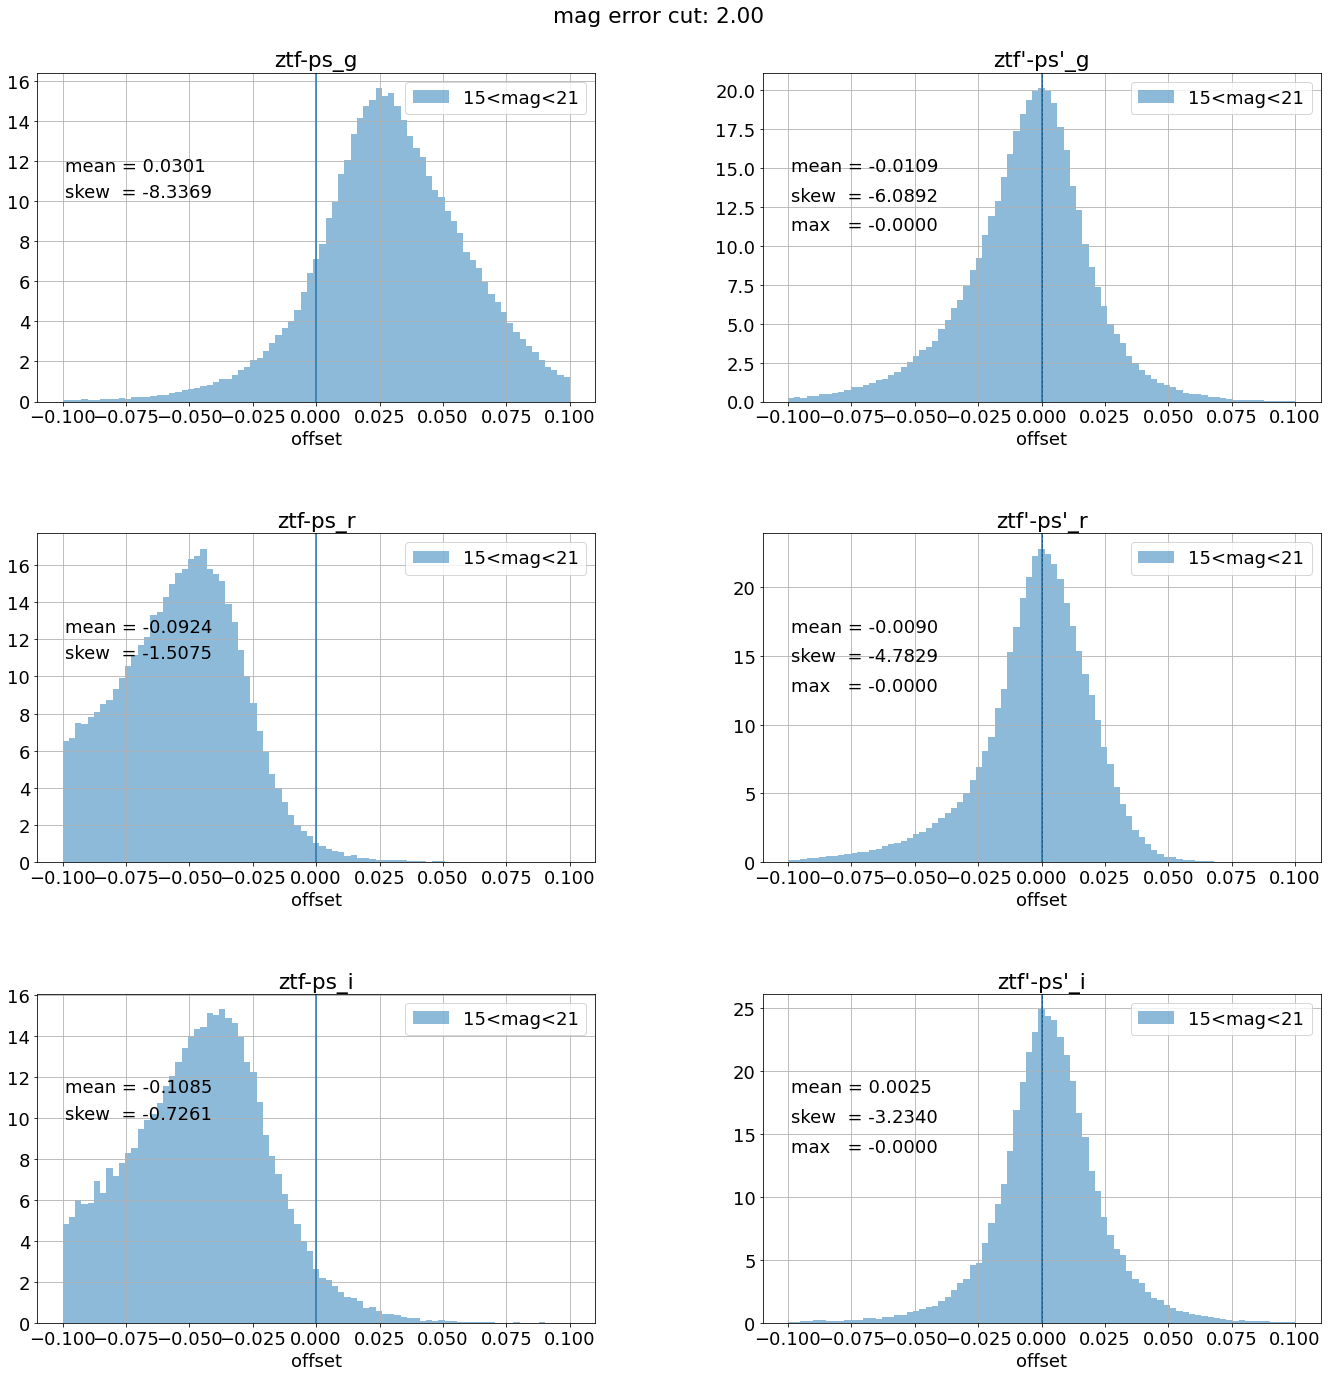

In [18]:
axes = ztf.plot_offset_distrib(ps, bands='gri', scale='linear', save=0, range=(-0.1,0.1), density=1, bins=bins)

#### Cells below plots a 2D histogram of the offset vs colour (try combine this into a grid of subplots)

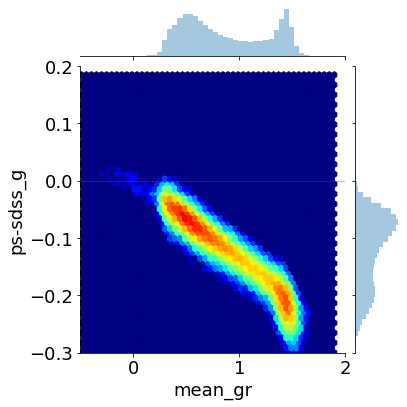

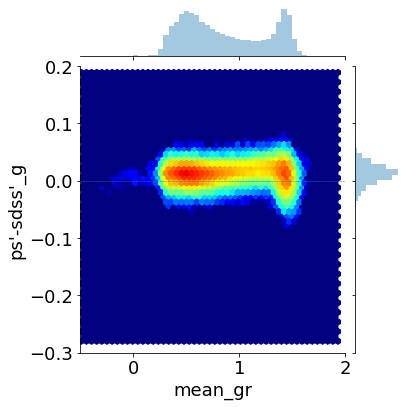

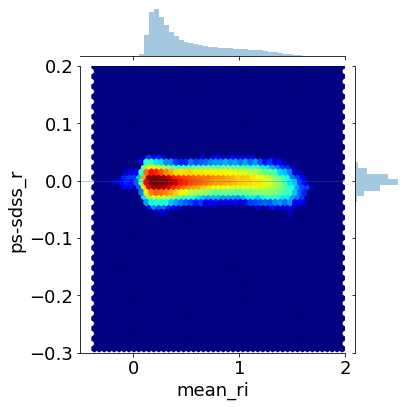

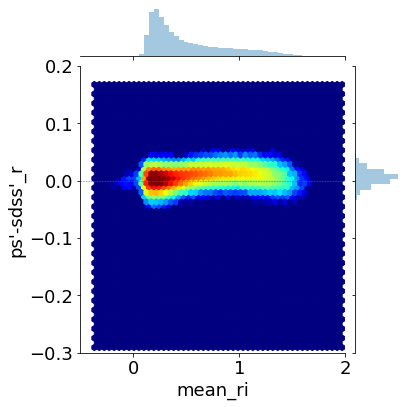

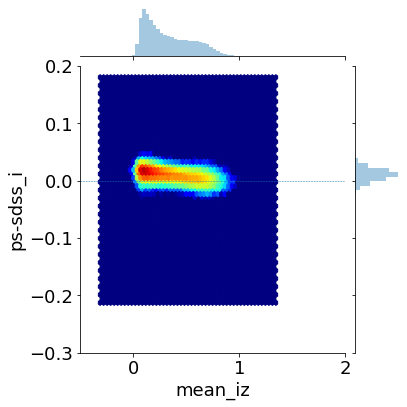

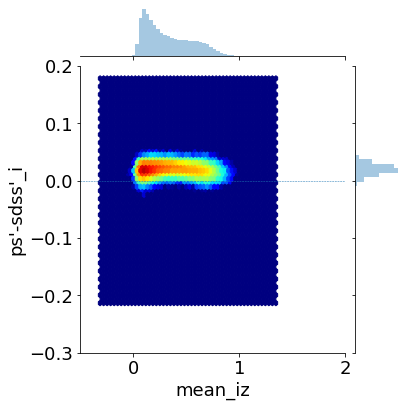

In [41]:
cmap = 'jet'

# ps.correlate_offset_color_hist_sns(sdss,'g', 'mean_gr', 1e0,1e5)
# ps.correlate_ofset_color_hist_sns(sdss,'g', 'mean_ri', 1e0,1e5)

# ps.correlate_offset_color_hist_sns(sdss,'r', 'mean_gr', 1e0,1e5)
# ps.correlate_offset_color_hist_sns(sdss,'r', 'mean_ri', 1e0,1e5)

# ps.correlate_offset_sns(sdss, 'i', 'mean_gr', 1e0,1e5, yrange=(-0.1,0.1))
# ps.correlate_offset_sns(sdss,'i', 'mean_ri', 1e0,1e5)

# ps.correlate_offset_sns(sdss,'z', 'mean_gr', 1e0,1e5)
# ps.correlate_offset_sns(sdss,'z', 'mean_ri', 1e0,1e5)
xrange = (-0.5,2)
# xrange = (16,21)
ps.correlate_offset_sns(sdss, 'g', 'mean_gr', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ps.correlate_offset_sns(sdss, 'r', 'mean_ri', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ps.correlate_offset_sns(sdss, 'i', 'mean_iz', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)

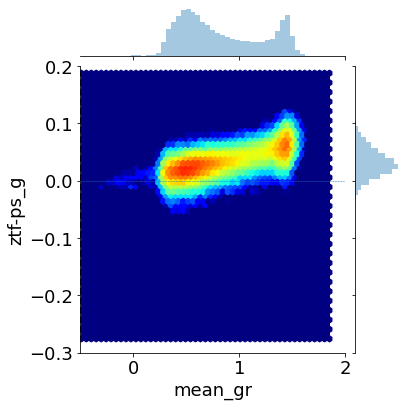

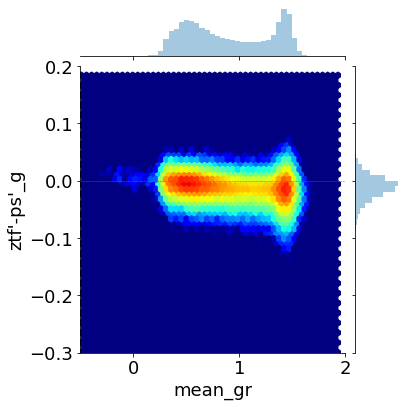

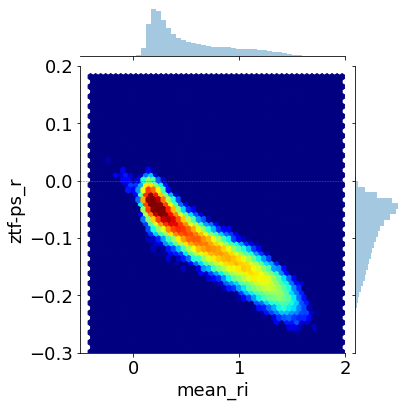

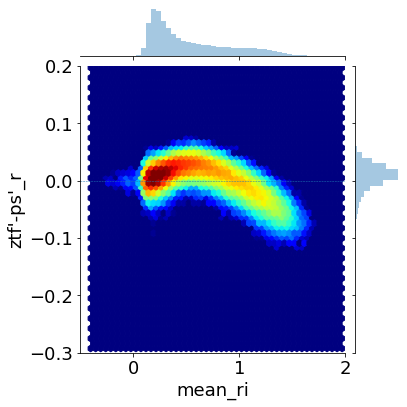

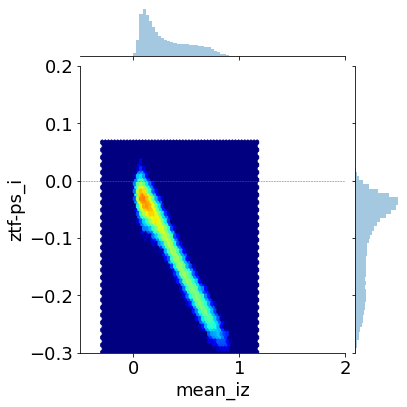

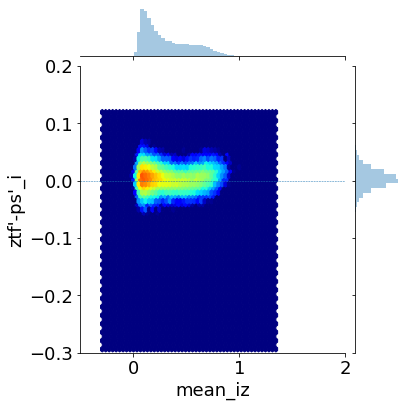

In [42]:
cmap = 'jet'
# xrange=(15,22.5)
ztf.correlate_offset_sns(ps, 'g', 'mean_gr', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ztf.correlate_offset_sns(ps, 'r', 'mean_ri', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ztf.correlate_offset_sns(ps, 'i', 'mean_iz', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)

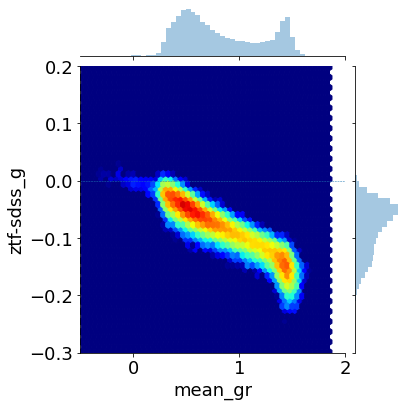

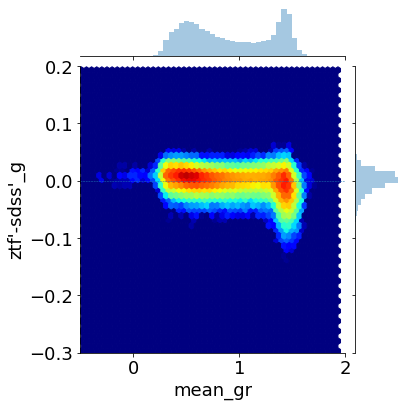

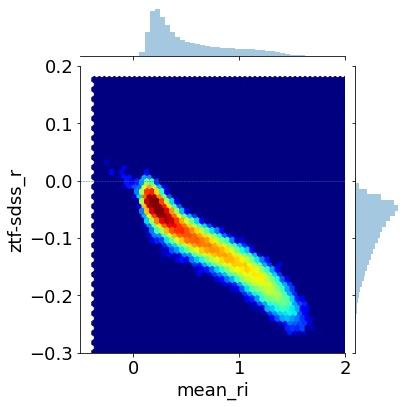

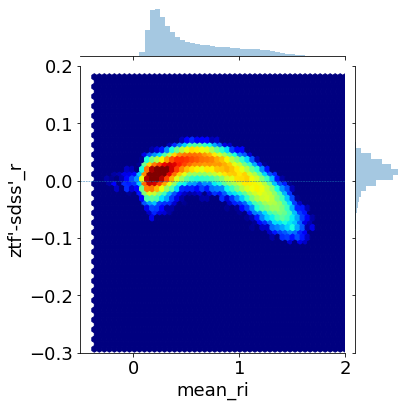

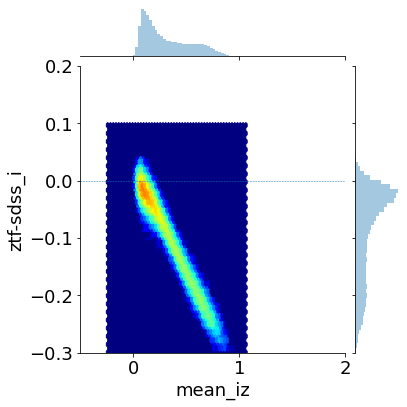

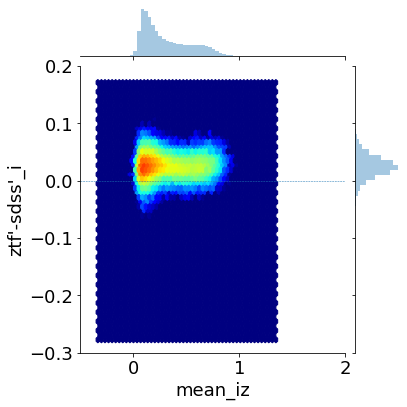

In [43]:
cmap = 'jet'
# xrange=(15,22.5)
ztf.correlate_offset_sns(sdss, 'g', 'mean_gr', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ztf.correlate_offset_sns(sdss, 'r', 'mean_ri', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)
ztf.correlate_offset_sns(sdss, 'i', 'mean_iz', pop, 1e1,3e3, xrange=xrange, yrange=(-0.3,0.2), save=1, cmap=cmap)

#### Cells below plots a distribution of errors on the mean magnitude for each population. We should repeat this for mag rather than meanmag.

def plot_magerr(self, range, bins):
    fig, ax = plt.subplots(3,1, figsize=(23,15))
    for i, b in enumerate('gri'):
        for name,mask in self.masks.iteritems():
            self.df_pivot.loc[mask, 'meanerr_'+b].hist(bins=bins, range=range, ax=ax[i], label=name, density=True, alpha = 0.5)#, cumulative=True, density=True)
     
    #     sdss.df_pivot[['meanerr_' + b for b in 'gri']].hist(bins=100,range=(0,0.15), ax=ax[0,:], label='sdss', cumulative=True, density=True, alpha=0.5)
    #     ps.  df_pivot[['meanerr_' + b for b in 'gri']].hist(bins=100,range=(0,0.06), ax=ax[1,:], label='ps', cumulative=True, density=True, alpha=0.5)
    #     ztf. df_pivot[['meanerr_' + b for b in 'gri']].hist(bins=100,range=(0,0.1), ax=ax[2,:], label='ztf', cumulative=True, density=True, alpha=0.5)

    for axis in ax:
        axis.set(yscale='log')
        axis.legend()

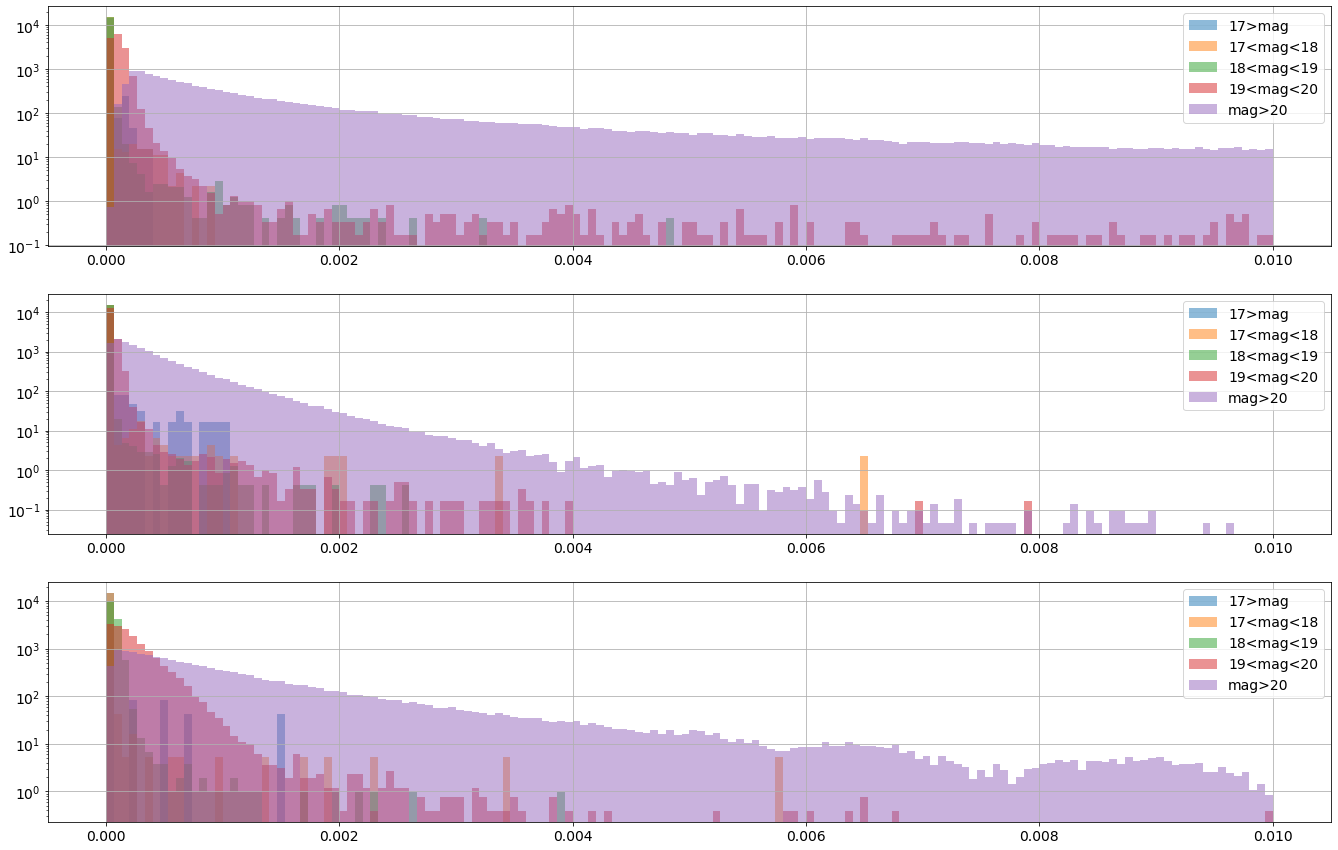

In [27]:
plot_magerr(ztf, range=(0,0.01), bins=150)

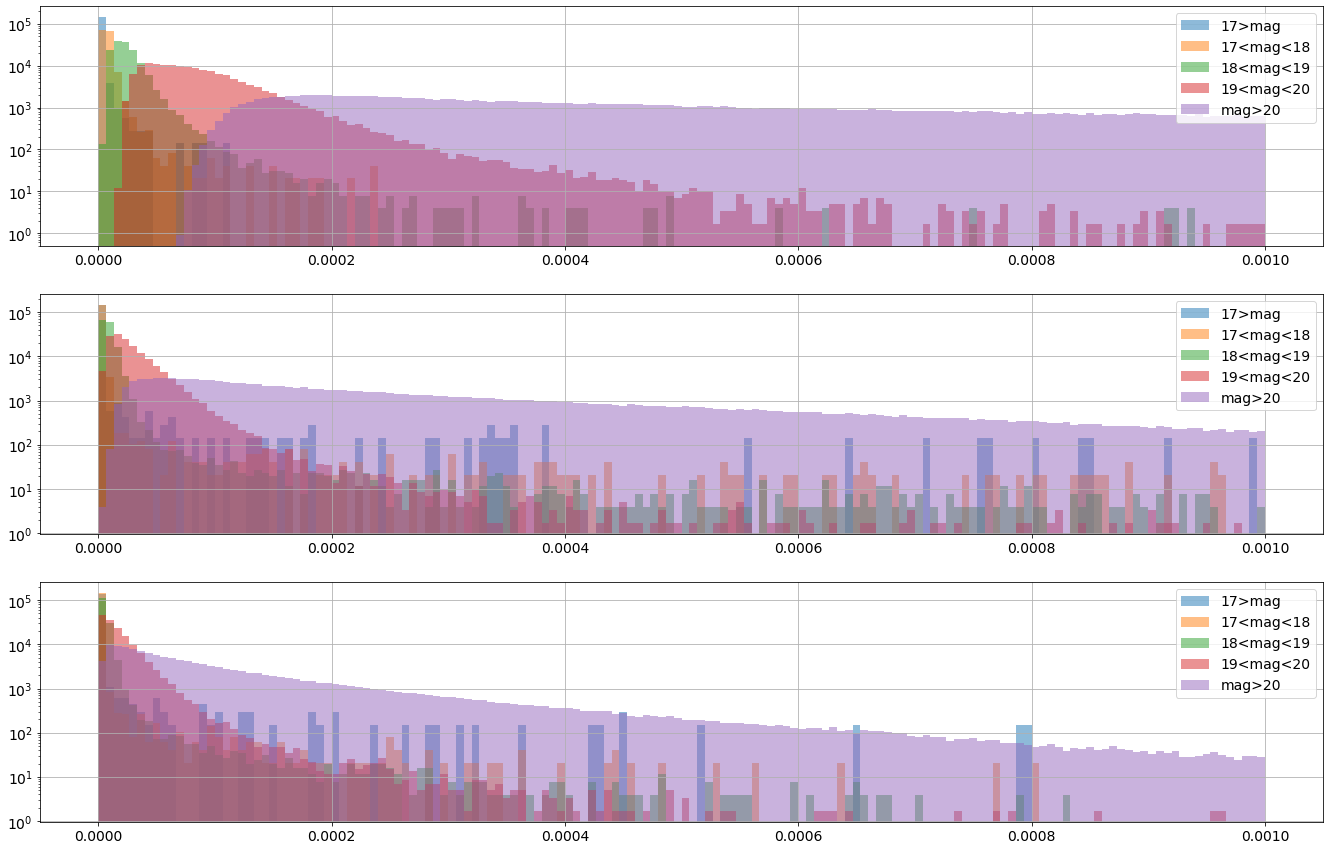

In [29]:
plot_magerr(ps, range=(0,0.001), bins=150)